<div style="text-align: right">Peter Norvig, Feb 2020</div> 

# Estimating Probabilities with Simulations

In [another notebook](http://nbviewer.jupyter.org/url/norvig.com/ipython/Probability.ipynb) I showed how to solve problems by computing probabilities. The computations are simple: count the frequency of the "favorable" outcomes and divide by the frequency of all possible outcomes&mdash;the "sample space." (In [yet another notebook](http://nbviewer.jupyter.org/url/norvig.com/ipython/Probability.ipynb) I tackle some probability paradoxes.)


But sometimes it is inconvenient, difficult, or even impossible to explicitly enumerate all possible outcomes. Perhaps the sample space is infinite, or perhaps it is just very large and complicated, with a bunch 
of low-probability outcomes that don't seem very important. In that case, we might feel more confident in writing a program to *simulate* a random outcome. *Random sampling* from such a simulation
can give an accurate estimate of probability.

# Simulating Monopoly

<img src="http://buckwolf.org/a.abcnews.com/images/Entertainment/ho_hop_go_050111_t.jpg" style="float:right">

Consider [problem 84](https://projecteuler.net/problem=84) from the excellent [Project Euler](https://projecteuler.net), which asks for the probability that a player in the game Monopoly ends a roll on each of the squares on the board.  To answer this we need to take into account die rolls, chance and community chest cards, and going to jail (from the "go to jail" space, from a card, or from rolling doubles three times in a row). We do not need to take into account anything about acquiring properties or exchanging money or winning or losing the game, because these events don't change a player's location. 

A game of Monopoly can go on forever, so the sample space is infinite. Even if we limit the sample space to say, 1000 rolls, there are $21^{1000}$ such sequences of rolls. So it is infeasible to explicitly represent the sample space. There are techniques for representing the problem as
a Markov decision problem (MDP) and solving it, but the math is complex (a [paper](https://faculty.math.illinois.edu/~bishop/monopoly.pdf) on the subject runs 15 pages).

The simplest approach is to implement a simulation and run it for, say, a million rolls.  Below is the code for a simulation. Squares are represented by integers from 0 to 39, and we define a global variable for each square: `GO`, `A1` (for the first property in the first monopoly), `CC1` (the first community chest square), and so on.  Wiithin the function `monopoly` the variable `loc` keeps track of where we are, and dice rolls and cards can alter the location. We use `visits[square]` to count how many times we end a roll on the square.

The trickiest part of the simulation is the cards: chance and community chest. We'll implement a deck of cards as a double-ended queue (so we can take cards from the top and put them on the bottom). Each card can be:
- A square, meaning to advance to that square (e.g., `R1` (square 5) means "take a ride on the Reading").
- A set of cards (e.g., `{R1, R2, R3, R4}` means "advance to nearest railroad").
- The number -3, which means "go back 3 squares".
- `'$'`, meaning the card has no effect on location, but involves money.



In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import random
from collections import Counter, deque

# The Monopoly board, as specified by https://projecteuler.net/problem=84
board = """
 GO    A1  CC1  A2   T1  R1  B1   CH1  B2  B3 
 JAIL  C1  U1   C2   C3  R2  D1   CC2  D2  D3  
 FP    E1  CH2  E2   E3  R3  F1   F2   U2  F3  
 G2J   G1  G2   CC3  G3  R4  CH3  H1   T2  H2""".split()

for i, sq in enumerate(board): # Make the square names be global variables
    globals()[sq] = i
    
def Deck(cards):
    """A deck of cards; draw from the top and put it on bottom."""
    random.shuffle(cards)
    return deque(cards)
    
CC_cards = Deck([GO, JAIL] +  14 * ['$'])
CH_cards = Deck([GO, JAIL, C1, E3, H2, R1, -3, {U1, U2}]
                + 2 * [{R1, R2, R3, R4}] + 6 * ['$'])

def roll() -> int: return random.randint(1, 6)

def monopoly(rolls):
    """Simulate a number of dice rolls of a Monopoly game, 
    and return the counts of how often each square is visited."""
    visits = len(board) * [0]  # Counts of how many times each square is visited
    doubles = 0                # Number of consecutive doubles rolled
    loc = GO                   # Location on board
    for _ in range(rolls):
        d1, d2 = roll(), roll()
        doubles = ((doubles + 1) if d1 == d2 else 0)
        loc = (loc + d1 + d2) % len(board) # Roll, move ahead, maybe pass Go
        if loc == G2J or doubles == 3:
            loc = JAIL
            doubles = 0
        elif loc in (CC1, CC2, CC3):
            loc = do_card(CC_cards, loc)
        elif loc in (CH1, CH2, CH3):
            loc = do_card(CH_cards, loc)
        visits[loc] += 1
    return visits

def do_card(deck, loc):
    "Take the top card from deck and do what it says; return new location."
    card = deck[0]                        # The top card
    deck.rotate(1)                        # Move top card to bottom of deck
    return (loc if card is '$' else       # Don't move
            loc - 3 if card == -3 else    # Go back 3 spaces
            card if isinstance(card, int) # Go to destination named on card
            else min({s for s in card if s > loc} or card)) # Advance to nearest

Let's run the simulation for a million dice rolls and print a bar chart of probabilities for each square:

In [2]:
N = 10**6

visits = monopoly(N)

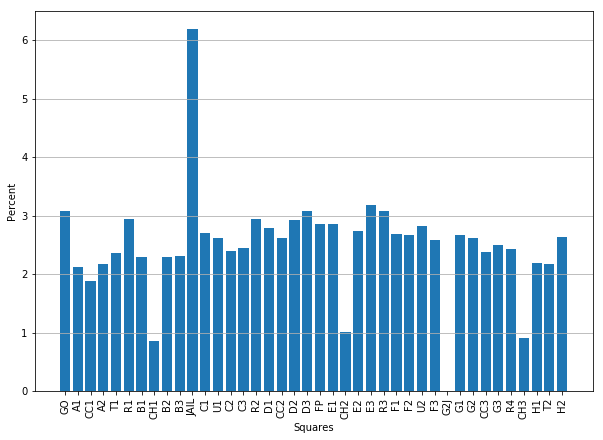

In [3]:
def bar(visits): 
    plt.rcParams["figure.figsize"] = [10, 7]
    plt.grid(axis='y')
    plt.xticks(range(40), board, rotation=90)
    plt.xlabel("Squares"); plt.ylabel("Percent")
    plt.bar(board, [100 * visits[s] / N for s in range(40)])
    
bar(visits)

If the squares were all visited equally, they'd each be 100% / 40 = 2.5%. In actuality, we see that most of the squares are between about 2% and 3%, but a few stand out:  `JAIL`is over 6%; `G2J` ("Go to Jail") is 0%, because you can't end a roll there; and the three chance squares (`CH1`, `CH2`, and `CH3`) are each at around 1%, because 10 of the 16 chance cards send the player away from the square. 

# The Central Limit Theorem 

The [Probability notebook](http://nbviewer.jupyter.org/url/norvig.com/ipython/Probability.ipynb) covered the concept of *distributions* of outcomes. You may have heard of the *normal distribution*, the *bell-shaped curve.* In Python it is called `random.normalvariate` (also `random.gauss`). We can plot it with the help of the `repeated_hist` function defined below, which samples a distribution `n` times and displays a histogram of the results. (*Note:* in this section I am implementing "distribution" as a function with no arguments that, each time it is called, returns a random sample from a probability distribution.)

In [4]:
from statistics import mean
from random import normalvariate, triangular, choice, vonmisesvariate, uniform

def normal(mu=0, sigma=1): return random.normalvariate(mu, sigma)

def repeated_hist(dist, n=10**6, bins=200):
    "Sample the distribution n times and make a histogram of the results."
    plt.rcParams["figure.figsize"] = [6, 4]
    samples = [dist() for _ in range(n)]
    plt.hist(samples, bins=bins, density=True)
    plt.title(f'{dist.__name__} (μ = {mean(samples):.1f})')
    plt.grid(axis='x')
    plt.yticks([], '')
    plt.show()

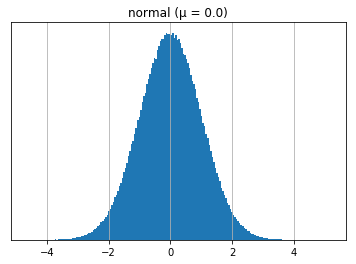

In [5]:
# Histogram of Normal distribution
repeated_hist(normal)

Why is this distribution called *normal*? The **Central Limit Theorem** says  that it is the ultimate limit of other distributions, as follows (informally):
- Gather *k* independent distributions. They need not be normal-shaped.
- Define a new distribution to be the result of sampling one number from each of the *k* independent distributions and adding them up.
- As long as *k* is not too small, and the component distributions are not super-pathological, then the new distribution will tend towards a normal distribution.

Here's a simple example: rolling a single die gives a uniform distribution:

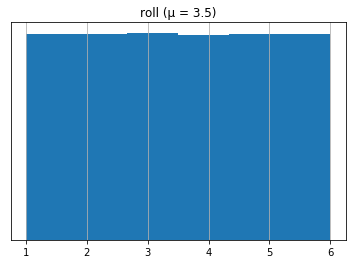

In [6]:
repeated_hist(roll, bins=6)

Rolling two dice gives a "staircase" distribution:

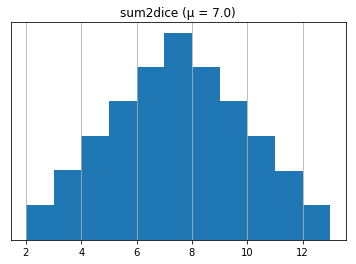

In [7]:
def sum2dice(): return roll() + roll()

repeated_hist(sum2dice, bins=range(2, 14))

But rolling N = 20 dice and summing them gives a near-normal distribution:

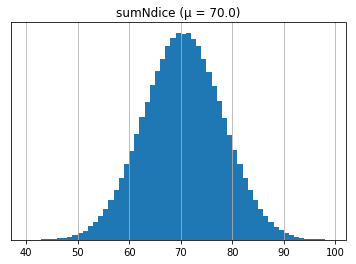

In [8]:
N = 20

def sumNdice(): return sum(roll() for _ in range(N))

repeated_hist(sumNdice, bins=range(2 * N, 5 * N))

As another example, let's take just *k* = 5 component distributions representing the per-game scores of 5 basketball players, and then sum them together to form the new distribution, the team score. I'll be creative in defining the distributions for each player, but [historically accurate](https://www.basketball-reference.com/teams/GSW/2016.html) in the mean for each distribution.

In [9]:
def SC(): return max(0, normal(12.1, 3) + 3 * triangular(1, 13, 4))                     # 30.1
def KT(): return max(0, triangular(8, 22, 15.3) + choice((0, 3 * triangular(1, 9, 4)))) # 22.1
def DG(): return max(0, vonmisesvariate(30, 2) * 3.08)                                  # 14.0
def HB(): return max(0, choice((normal(6.7, 1.5), normal(16.7, 2.5))))                  # 11.7
def BE(): return max(0, normal(17, 3) + uniform(0, 40))                                 # 37.0

team = (SC, KT, DG, HB, BE)

def Team(team=team): return sum(player() for player in team)

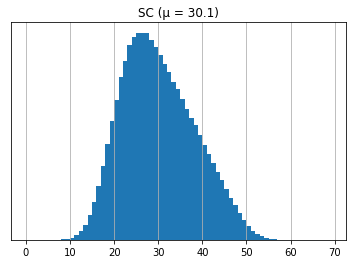

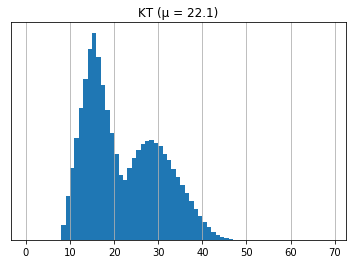

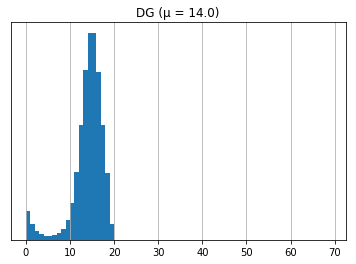

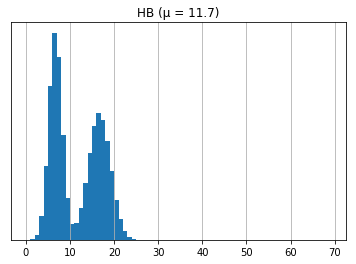

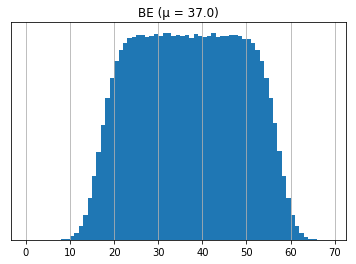

In [10]:
for player in team: 
    repeated_hist(player, bins=range(70))

We can see that none of the players have a distribution that looks like a normal distribution: `SC` is skewed to one side (the mean is 5 points to the right of the peak); the three next players have bimodal distributions; and `BE` is too flat on top. 

Now we define the team score to be the sum of the *k* = 5 players, and display this new distribution:

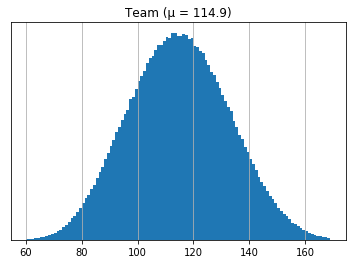

In [11]:
repeated_hist(Team, bins=range(60, 170))

Sure enough, this looks very much like a normal distribution. The **Central Limit Theorem** appears to hold in this case. But I have to say: "Central Limit" is not a very evocative name, so I propose we re-name this as the **Strength in Numbers Theorem**, to indicate the fact that if you have a lot of numbers, you tend to get the expected result.

<hr>

# Appendix: Continuous Sample Spaces

Everything up to here has been about discrete, finite sample spaces, where we can *enumerate* all the possible outcomes. 

But a reader asked about *continuous* sample spaces, such as the space of real numbers. The principles are the same: probability is still the ratio of the favorable cases to all the cases, but now instead of *counting* cases, we have to (in general) compute integrals to compare the sizes of cases. 
Here we will cover a simple example, which we first solve approximately by simulation, and then exactly by calculation.

## The Hot New Game Show Problem: Simulation

Oliver Roeder posed [this problem](http://fivethirtyeight.com/features/can-you-win-this-hot-new-game-show/) in the 538 *Riddler* blog:

>Two players go on a hot new game show called *Higher Number Wins.* The two go into separate booths, and each presses a button, and a random number between zero and one appears on a screen. (At this point, neither knows the other’s number, but they do know the numbers are chosen from a standard uniform distribution.) They can choose to keep that first number, or to press the button again to discard the first number and get a second random number, which they must keep. Then, they come out of their booths and see the final number for each player on the wall. The lavish grand prize — a case full of gold bullion — is awarded to the player who kept the higher number. Which number is the optimal cutoff for players to discard their first number and choose another? Put another way, within which range should they choose to keep the first number, and within which range should they reject it and try their luck with a second number?

We'll use this notation:
- **A,** **B:** the two players.
-  $A$, $B$: the cutoff values they choose: the lower bound of the range of first numbers they will accept.
- $a$, $b$: the actual random numbers that appear on the screen.

For example, if player **A** chooses a cutoff of $A$ = 0.6, that means that **A** would accept any first number greater than 0.6, and reject any number below that cutoff. The question is: What cutoff, $A$, should player **A** choose to maximize the chance of winning, that is, maximize P($a$ > $b$)?

First, simulate the number that a player with a given cutoff gets (note that `random.random()` returns a float sampled uniformly from the interval [0..1]):

In [12]:
import itertools
import numpy as np

In [13]:
number = random.random

def strategy(cutoff):
    "Play the game with given cutoff, returning the first or second random number."
    first = number()
    return first if first > cutoff else number()

In [14]:
strategy(.5)

0.23132261507622254

Now compare the numbers returned with a cutoff of $A$ versus a cutoff of $B$, and repeat for a large number of trials; this gives us an estimate of the probability that cutoff $A$ is better than cutoff $B$:

In [15]:
def Pwin(A, B, trials=20000):
    "The probability that cutoff A wins against cutoff B."
    return mean(strategy(A) > strategy(B) 
                for _ in range(trials))

In [16]:
Pwin(0.6, 0.9)

0.5616

Now define a function, `top`, that considers a collection of possible cutoffs, estimate the probability for each cutoff playing against each other cutoff, and returns a list with the `N` top cutoffs (the ones that defeated the most number of opponent cutoffs), and the number of opponents they defeat: 

In [17]:
def top(N, cutoffs):
    "Return the N best cutoffs and the number of opponent cutoffs they beat."
    winners = Counter(A if Pwin(A, B) > 0.5 else B
                      for (A, B) in itertools.combinations(cutoffs, 2))
    return winners.most_common(N)

In [18]:
top(10, np.arange(0.5, 1.0, 0.01))

[(0.6200000000000001, 45),
 (0.5800000000000001, 44),
 (0.6100000000000001, 44),
 (0.55, 43),
 (0.5900000000000001, 43),
 (0.53, 41),
 (0.54, 41),
 (0.5700000000000001, 41),
 (0.6300000000000001, 41),
 (0.6400000000000001, 41)]

We get a good idea of the top cutoffs, but they are close to each other, so we can't quite be sure which is best, only that the best is somewhere around 0.60. We could get a better estimate by increasing the number of trials, but that would consume more time.

## The Hot New Game Show Problem: Exact Calculation

More promising is the possibility of making `Pwin(A, B)` an exact calculation. But before we get to `Pwin(A, B)`, let's solve a simpler problem: assume that both players **A** and **B** have chosen a cutoff, and have each received a number above the cutoff. What is the probability that **A** gets the higher number? We'll call this `Phigher(A, B)`. We can think of this as a two-dimensional sample space of points in the ($a$, $b$) plane, where$a$ ranges from the cutoff $A$ to 1 and $b$ ranges from the cutoff B to 1. Here is a diagram of that two-dimensional sample space, with the cutoffs $A$=0.5 and $B$=0.6:

<img src="http://norvig.com/ipython/probability2da.jpg" width=413>

The total area of the sample space is 0.5 &times; 0.4 = 0.20, and in general it is (1 - $A$) &middot; (1 - $B$). What about the favorable cases, where **A** beats **B**? That corresponds to the shaded triangle below:

<img src="http://norvig.com/ipython/probability2d.jpg" width=413>

The area of a triangle is 1/2 the base times the height, or in this case, 0.4<sup>2</sup> / 2 = 0.08, and in general, (1 - $B$)<sup>2</sup> / 2. So in general we have:

    Phigher(A, B) = favorable / total
    favorable     = ((1 - B) ** 2) / 2 
    total         = (1 - A) * (1 - B)
    Phigher(A, B) = (((1 - B) ** 2) / 2) / ((1 - A) * (1 - B))
    Phigher(A, B) = (1 - B) / (2 * (1 - A))
    
And in this specific case we have:

     A = 0.5; B = 0.6
     favorable         = 0.4 ** 2 / 2 = 0.08
     total             = 0.5 * 0.4    = 0.20
     Phigher(0.5, 0.6) = 0.08 / 0.20  = 0.4

But note that this only works when the cutoff $A$ &le; $B$; when $A$ > $B$, we need to reverse things. That gives us the code:

In [19]:
def Phigher(A, B):
    "Probability that a uniform sample from [A..1] is higher than one from [B..1]."
    if A <= B:
        return (1 - B) / (2 * (1 - A))
    else:
        return 1 - Phigher(B, A)

In [20]:
Phigher(0.5, 0.6)

0.4

We're now ready to tackle the full game. There are four cases to consider, depending on whether **A** and **B** gets a first number that is above or below their cutoff choices:

| first $a$ | first $b$ | P($a$, $b$) | P(A wins│ $a$, $b$) |  Comment |
|:-----:|:-----:| ----------- | ------------- | ------------ |
|$a$ > $A$ | $b$ > $B$ | (1 - $A$) &middot; (1 - $B$) | Phigher(*A*, $B$) | Both above cutoff; both keep first numbers |
|$a$ < $A$ | $b$ < $B$ | $A$ &middot; $B$ | Phigher(0, 0)  | Both below cutoff, both get new numbers from [0..1] |
|$a$ > $A$ | $b$ < $B$ | (1 - $A$) &middot;  $B$ | Phigher($A$, 0) | **A** keeps number; **B** gets new number from [0..1] |
|$a$ < $A$ | $b$ > $B$ | $A$ &middot; (1 - $B$) | Phigher(0, $B$) | **A** gets new number from [0..1]; **B** keeps number |

For example, the first row of this table says that the event of both first numbers being above their respective cutoffs has probability (1 - $A$) &middot; (1 - $B$), and if this does occur, then the probability of **A** winning is Phigher(*A*, $B$).
We're ready to replace the old simulation-based `Pwin` with a new calculation-based version:

In [21]:
def Pwin(A, B):
    "With what probability does cutoff A win against cutoff B?"
    return ((1-A) * (1-B) * Phigher(A, B)  # both above cutoff; both keep 1st number
            + A * B       * Phigher(0, 0)  # both below cutoff; both get new numbers
            + (1-A) * B   * Phigher(A, 0)  # A above, B below; B gets new number
            + A * (1-B)   * Phigher(0, B)) # A below, B above; A gets new number

In [22]:
Pwin(0.5, 0.6)

0.495

`Pwin` relies on a lot of algebra. Let's define a few tests to check for obvious errors:

In [23]:
def test():
    assert Phigher(0.5, 0.5) == Phigher(0.75, 0.75) == Phigher(0, 0) == 0.5
    assert Pwin(0.5, 0.5) == Pwin(0.75, 0.75) == 0.5
    assert Phigher(.6, .5) == 0.6
    assert Phigher(.5, .6) == 0.4
    return 'ok'

test()

'ok'

Let's repeat the calculation with our new, exact `Pwin`:

In [24]:
top(10, np.arange(0.5, 1.0, 0.01))

[(0.6200000000000001, 49),
 (0.6100000000000001, 48),
 (0.6000000000000001, 47),
 (0.5900000000000001, 46),
 (0.6300000000000001, 45),
 (0.5800000000000001, 44),
 (0.5700000000000001, 43),
 (0.6400000000000001, 42),
 (0.56, 41),
 (0.55, 40)]

It is good to see that the simulation and the exact calculation are in rough agreement; that gives me more confidence in both of them. We see here that 0.62 defeats all the other cutoffs (there are 50 cutoffs and it defeated the 49 others), and 0.61 defeats all cutoffs except 0.62. The great thing about the exact calculation code is that it runs fast, regardless of how much accuracy we want. We can zero in on the range around 0.6:

In [25]:
top(10, np.arange(0.5, 0.7, 0.001))

[(0.6180000000000001, 199),
 (0.6170000000000001, 198),
 (0.6160000000000001, 197),
 (0.6190000000000001, 196),
 (0.6150000000000001, 195),
 (0.6140000000000001, 194),
 (0.6130000000000001, 193),
 (0.6200000000000001, 192),
 (0.6120000000000001, 191),
 (0.6110000000000001, 190)]

This says 0.618 is best. We can get even more accuracy:

In [26]:
top(10, np.arange(0.617, 0.619, 0.000001))

[(0.6180340000000297, 2000),
 (0.6180330000000297, 1999),
 (0.6180320000000297, 1998),
 (0.6180350000000298, 1997),
 (0.6180310000000296, 1996),
 (0.6180300000000296, 1995),
 (0.6180290000000296, 1994),
 (0.6180360000000298, 1993),
 (0.6180280000000296, 1992),
 (0.6180270000000295, 1991)]

So 0.618034 is best. Does that number [look familiar](https://en.wikipedia.org/wiki/Golden_ratio)? Can we prove that it is what I think it is?

To understand the strategic possibilities, it is helpful to draw a 3D plot of `Pwin(A, B)` for values of $A$ and $B$ between 0 and 1:

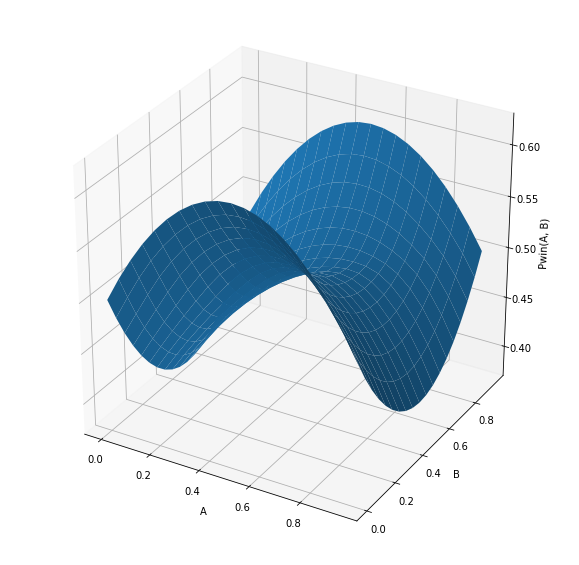

In [27]:
from mpl_toolkits.mplot3d.axes3d import Axes3D

def map2(fn, A, B):
    "Map fn to corresponding elements of 2D arrays A and B."
    return [[fn(a, b) for (a, b) in zip(Arow, Brow)]
            for (Arow, Brow) in zip(A, B)]

def plot3d(fn):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(0, 1.0, 0.05)
    X, Y = np.meshgrid(x, y)
    Z = np.array(map2(fn, X, Y))
    ax.plot_surface(X, Y, Z)
    ax.set_xlabel('A')
    ax.set_ylabel('B')
    ax.set_zlabel('Pwin(A, B)')
    
plot3d(Pwin)

What does this [Pringle of Probability](http://fivethirtyeight.com/features/should-you-shoot-free-throws-underhand/) show us? The highest win percentage for **A**, the peak of the surface, occurs when $A$ is around 0.5 and $B$ is 0 or 1. We can confirm that, finding the maximum `Pwin(A, B)` for many different cutoff values of `A` and `B`:

In [28]:
cutoffs = (set(np.arange(0.00,    1.00,    0.01)) | 
           set(np.arange(0.500,   0.700,   0.001)) | 
           set(np.arange(0.61803, 0.61804, 0.000001)))

def Pwin_summary(A, B): return (Pwin(A, B), 'A:', A, 'B:', B)

In [29]:
max(Pwin_summary(A, B) for A in cutoffs for B in cutoffs)

(0.625, 'A:', 0.5, 'B:', 0.0)

So **A** could win 62.5% of the time if only **B** would chose a cutoff of 0. But, unfortunately for **A**, a rational player **B** is not going to do that. We can ask what happens if the game is changed so that player **A** has to declare a cutoff first, and then player **B** gets to respond with a cutoff, with full knowledge of **A**'s choice. In other words, what cutoff should **A** choose to maximize `Pwin(A, B)`, given that **B** is going to take that knowledge and pick a cutoff that minimizes `Pwin(A, B)`? 

In [30]:
max(min(Pwin_summary(A, B) for B in cutoffs)
    for A in cutoffs)

(0.5, 'A:', 0.6180340000000001, 'B:', 0.6180340000000001)

And what if we run it the other way around, where **B** chooses a cutoff first, and then **A** responds?

In [31]:
min(max(Pwin_summary(A, B) for A in cutoffs)
    for B in cutoffs)

(0.5, 'A:', 0.6180340000000001, 'B:', 0.6180340000000001)

In both cases, the rational choice for both players is a cutoff of 0.618034, which corresponds to the  "saddle point" in the middle of the plot. This is a *stable equilibrium*; consider fixing $B$ = 0.618034, 
and notice that if $A$ changes to any other value, we slip off the saddle to the right or left, resulting in a worse win probability for **A**. Similarly, if we fix $A$ = 0.618034, then if $B$ changes to another value, we ride up the saddle to a higher win percentage for **A**, which is worse for **B**. So neither player will want to move from the saddle point.

The moral for continuous spaces is the same as for discrete spaces: be careful about defining your sample space; measure carefully, and let your code take care of the rest.